<a href="https://colab.research.google.com/github/timou0911/ML-DL-Learning/blob/main/BoW_Classification_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework4: Traffic Sign Classification

Using the data and some code from the practical exercises in class, perform the following tasks:

1. Experiment with the Bag-of-Words (BoW) feature extraction algorithm using different sizes of the dictionary. Plot the accuracy on the test set for each case.

2. Use Grid Search combined with Cross Validation to find the best parameters for the SVM model.

3. Replace SVM with other classifiers: K-Nearest Neighbors, Decision Tree, Random Forest. Compare the results and provide observations.

4. Use HOG to represent images and apply a classifier to classify the images.



## 0. Preparation

### 0-1. Data Preparation

In [ ]:
import os
import gdown


# Create a directory if it doesn't exist
os.makedirs("datas", exist_ok=True)

# URL of the file to download
url = 'https://drive.google.com/drive/folders/10YmNykgL6CqT0nPlbhUEmiYc3RrJy3zC?usp=drive_link'

# Download the file into the data directory
gdown.download_folder(url, output='datas', quiet=False)
import warnings
warnings.filterwarnings('ignore')

!unzip /content/datas/datas.zip

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

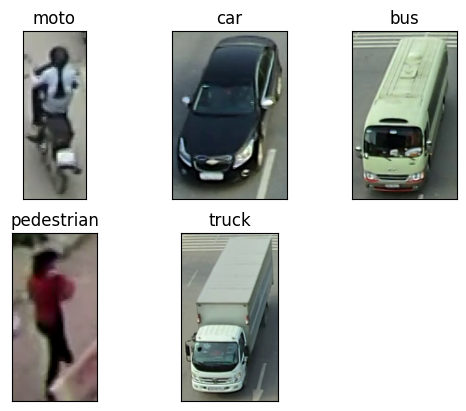

In [4]:
samples_list = []
samples_label = []
path_data_train = "datas/6_dataset/trainingset"
for label in os.listdir(path_data_train,):
    sample_file = os.listdir(os.path.join(path_data_train, label))[0]

    samples_list.append(cv2.imread(os.path.join(path_data_train, label, sample_file)))

    samples_label.append(label)

for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])

plt.show()

### 0-2. Data Statistics & Building a List to Store Images

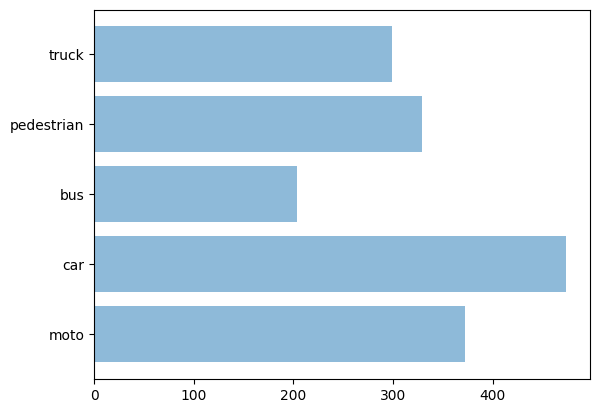

Total images: 1678


In [5]:
def statistic():
    label = []
    num_images = []
    for lab in os.listdir(path_data_train):
        label.append(lab)
        num_images.append(len(os.listdir(os.path.join(path_data_train, lab))))
    return label, num_images

label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

In [6]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir(path_data_train):
        for img_file in os.listdir(os.path.join(path_data_train, label)):
            img = cv2.imread(os.path.join(path_data_train, label, img_file))
            X.append(img)
            Y.append(label2id[label])
    return X, Y

# Label to id, used to convert string label to integer
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
for i in range(10):
    print(X[i].shape)
    print(Y[i])

1678
1678
(102, 38, 3)
1
(105, 49, 3)
1
(116, 59, 3)
1
(84, 38, 3)
1
(83, 46, 3)
1
(48, 26, 3)
1
(105, 53, 3)
1
(84, 29, 3)
1
(72, 35, 3)
1
(102, 51, 3)
1


## 1. BoW Feature Extraction Using Different Sizes of the Dictionary

### 1-1. Extracting SIFT Features

In [ ]:
def extract_sift_features(X):
    image_descriptors = []
    # sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create() ;
    for i in range(len(X)):
        _, des = sift.detectAndCompute(X[i], None)
        image_descriptors.append(des)

    return image_descriptors

image_descriptors = extract_sift_features(X)

print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1678
<class 'numpy.ndarray'>
Image 0 has 61 descriptors
Image 1 has 61 descriptors
Image 2 has 63 descriptors
Image 3 has 36 descriptors
Image 4 has 42 descriptors
Image 5 has 16 descriptors
Image 6 has 54 descriptors
Image 7 has 56 descriptors
Image 8 has 43 descriptors
Image 9 has 58 descriptors


### 1-2. Building the Dictionary (Bag-of-Words)

In [ ]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 155516
1678


In [ ]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

### 1-3. Building Feature Vectors with BoW Model

In [ ]:
from scipy.spatial.distance import cdist
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)

            for j in argmin:
                features[j] += 1

        X_features.append(features)


    return X_features

### 1-4. Find the Best Cluster Number

Accuracy for 40 clusters: 0.7351190476190477
Accuracy for 50 clusters: 0.7172619047619048
Accuracy for 60 clusters: 0.7440476190476191
Accuracy for 70 clusters: 0.7440476190476191
Accuracy for 80 clusters: 0.7589285714285714
Accuracy for 90 clusters: 0.7321428571428571
Accuracy for 100 clusters: 0.7440476190476191
Best model saved with 80 clusters and accuracy of 0.7589285714285714


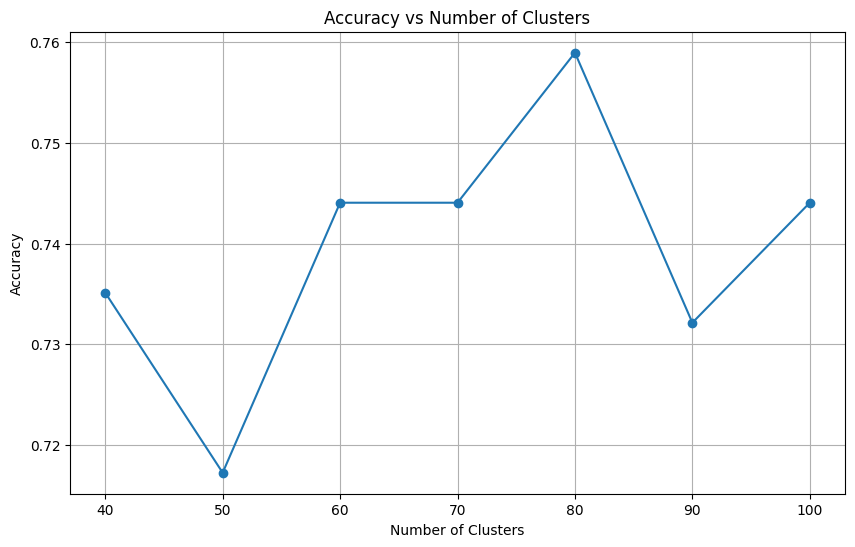

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

accuracies = []
cluster_numbers = range(40, 101, 10)
best_accuracy = 0
best_num_clusters = 0
best_X_features = None
best_svm = None

for num_clusters in cluster_numbers:
  BoW = kmeans_bow(all_descriptors, num_clusters)
  X_features = create_features_bow(image_descriptors, BoW, num_clusters)
  X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
  id_train, id_test = train_test_split(range(len(X_features)), test_size=0.2, random_state=42)

  svm = sklearn.svm.SVC(C = 30)
  svm.fit(X_train, Y_train)
  y_pred = svm.predict(X_test)
  accuracy = accuracy_score(Y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Accuracy for {num_clusters} clusters: {accuracy}")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_svm = svm
    best_num_clusters = num_clusters
    best_X_features = X_features
    best_bow = BoW

print(f"Best model saved with {best_num_clusters} clusters and accuracy of {best_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, accuracies, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Clusters')
plt.grid(True)
plt.show()

## 2. Find the Best Hyperparameters for SVM (Grid Search + Cross Validation)

### 2-1. Grid Search

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']}

X_train, X_test, Y_train, Y_test = train_test_split(best_X_features, Y, test_size=0.2, random_state=42)
id_train, id_test = train_test_split(range(len(X_features)), test_size=0.2, random_state=42)

svm = GridSearchCV(SVC(), param_grid, cv=5)
svm.fit(X_train, Y_train)
print('Best model', end='')
print(svm.best_estimator_)

Best modelSVC(C=10, gamma=0.001)


### 2-2. SVM Model & Evaluation

              precision    recall  f1-score   support

  pedestrian      0.836     0.859     0.847        71
        moto      0.747     0.776     0.761        76
       truck      0.698     0.682     0.690        44
         car      0.748     0.830     0.787       100
         bus      0.833     0.556     0.667        45

    accuracy                          0.768       336
   macro avg      0.772     0.741     0.750       336
weighted avg      0.771     0.768     0.765       336

Accuracy:  0.7678571428571429


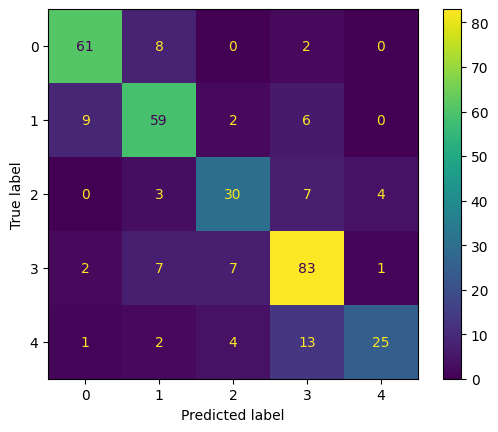

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,  confusion_matrix , classification_report

Y_predict = svm.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=svm.classes_)
ConfusionMatrixDisplay(cm, display_labels=svm.classes_).plot(values_format='d')
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

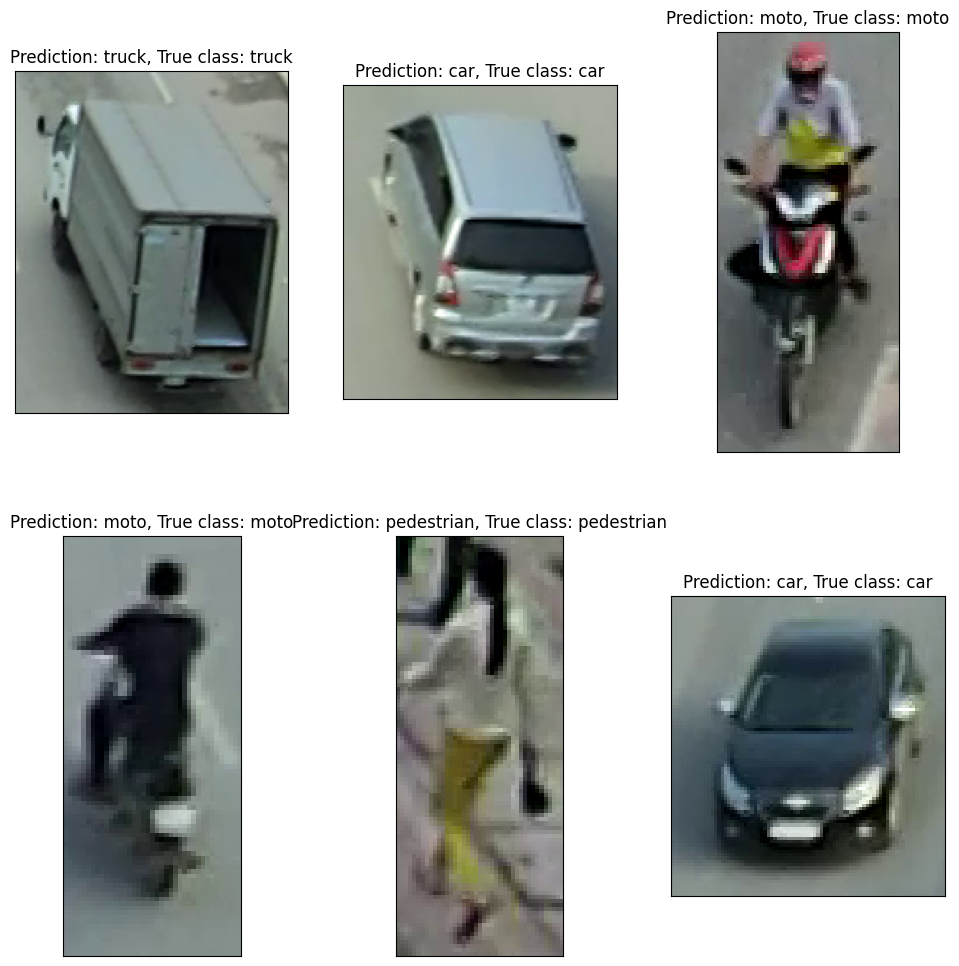

In [ ]:
id2label = {j:i for i,j in label2id.items()} # reverse
plt.figure(figsize=(12, 12))
for i in range(6): # plot 6 images
    img_id = id_test[i] # X[img_id] is the i-th image in the test set
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(X[img_id], cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {id2label[Y_predict[i]]}, True class: {id2label[Y_test[i]]}"), plt.xticks([]), plt.yticks([])
plt.show()

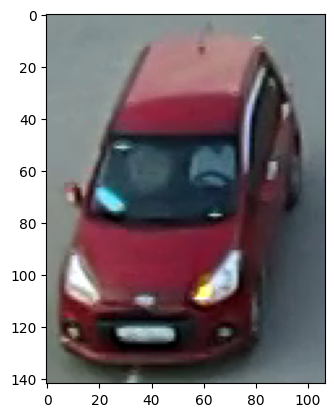

(142, 107, 3)


In [ ]:
img = cv2.imread('datas/6_dataset/image_test/car.png')


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img.shape)
my_X = [img]

In [ ]:
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, best_bow, best_num_clusters)

print(len(my_image_descriptors[0]))
print(my_X_features[0].shape)

106
(80,)


In [ ]:
y_pred = svm.predict(my_X_features)

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Your prediction:  car


## 3. Replace SVM with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

rf = GridSearchCV(estimator=RandomForestClassifier(), cv=5, param_grid=dict_param)
rf.fit(X_train, Y_train)
print('Best model', end='')
print(rf.best_estimator_)

Best modelRandomForestClassifier(max_depth=20, min_samples_leaf=5)


              precision    recall  f1-score   support

  pedestrian      0.845     0.845     0.845        71
        moto      0.727     0.842     0.780        76
       truck      0.609     0.636     0.622        44
         car      0.672     0.780     0.722       100
         bus      0.933     0.311     0.467        45

    accuracy                          0.726       336
   macro avg      0.757     0.683     0.687       336
weighted avg      0.748     0.726     0.714       336

Accuracy:  0.7261904761904762


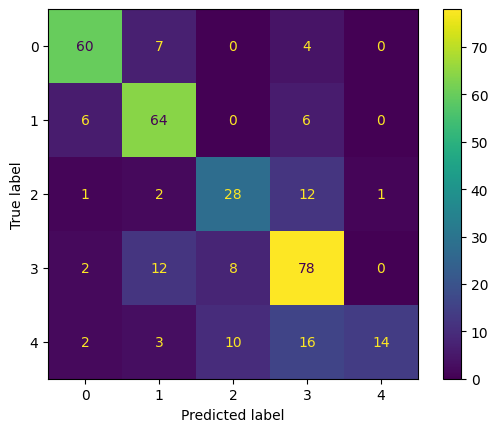

In [ ]:
Y_predict = rf.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=rf.classes_)
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(values_format='d')
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

## 4. Use HOG to represent images and apply a classifier

In [11]:
from skimage.feature import hog

def extract_hog_features(X, image_size=(128, 128)):
    hog_features = []
    for img in X:
        img_resized = cv2.resize(img, image_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        features, _ = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

hog_features = extract_hog_features(X)

In [12]:
print("Shape of hog_features:", hog_features.shape)
print("Shape of first feature vector:", hog_features[0].shape)

if None in hog_features:
    print("Warning: None values detected in hog_features")

Shape of hog_features: (1678, 512)
Shape of first feature vector: (512,)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(hog_features, Y, test_size=0.2, random_state=42)

svm = sklearn.svm.SVC(C=10, gamma=0.001)
svm.fit(X_train, Y_train)

accuracy = svm.score(X_test, Y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9285714285714286
